# Programowanie współbieżne i równoległe

## Wątki, zadania, synchronizacja, monitory, wartości atomowe, kolekcje

<br/>

## dr inż. Aleksander Smywiński-Pohl, Michał Idzik



Część przykładów pochodzi ze strony:
http://winterbe.com

# Java + Threads

<img src="img/thread.png" width="300"/>

# Program, proces, wątek

<img src="img/process_and_thread.png"/>

* program - plik lub zestaw plików opisujących w jakis sposób należy przetwarzać dane
* proces - uruchomiony program posiadający własną pamięć oraz licznik instrukcji
* wątek - lekki proces w obrębie działającego programu, posiadający własny stos oraz licznik instrukcji

# Klasa `Thread`

<img src="img/thread-1.png" />

API klasy `Thread`:
* `run()`
* `start()`
* `join()`
* `currentThread()`
* `getName()`
* ...

In [ ]:
import static java.lang.System.out;
import java.util.List;
import java.util.LinkedList;

List<Thread> threads = new LinkedList<>();

out.println("Wątek główny " + Thread.currentThread().getName());

threads.add(new Thread(() -> out.println("Wątek " + Thread.currentThread().getName())));
threads.add(new Thread(() -> out.println("Wątek " + Thread.currentThread().getName())));
threads.add(new Thread(() -> out.println("Wątek " + Thread.currentThread().getName())));

threads.forEach(Thread::start);
for(Thread thread : threads){
    thread.join();
}

# Interfejs `Runnable`

&nbsp;

<img src="img/runner.jpg" width="800"/>

API interfejsu `Runnable`:
* `run()`

In [ ]:
class Task implements Runnable {
    public void run() {
        System.out.println(Thread.currentThread().getName());
    }
}

Task task = new Task();
Thread thread = new Thread(task);
thread.start();
// thread.join();

Alternatywnie: **klasa anonimowa**

In [ ]:
Runnable task = new Runnable() {
    public void run() {
        System.out.println(Thread.currentThread().getName());
    } 
}

...co można też zapisać jako **wyrażenie lambda**:

In [ ]:
Runnable task = () -> System.out.println(Thread.currentThread().getName());

In [ ]:
import static java.lang.System.out;
import java.util.List;
import java.util.LinkedList;

List<Runnable> tasks = new LinkedList<>();

tasks.add(() -> out.println("Zadanie " + Thread.currentThread().getName()));
tasks.add(() -> out.println("Zadanie " + Thread.currentThread().getName()));
tasks.add(() -> out.println("Zadanie " + Thread.currentThread().getName()));

List<Thread> threads = new LinkedList<>();
tasks.forEach((task) -> threads.add(new Thread(task)));

threads.forEach(Thread::start);
//for(Thread t : threads) {
//        t.join();
//}


# `Thread#sleep()`

&nbsp;
<img src="img/sleeping_cat.jpg"/>

In [ ]:
import static java.lang.System.out;
import java.util.concurrent.*;

Thread sleepingThread = new Thread(() -> {
    try{
        out.println("Idę spać na 3 sekudny");
        TimeUnit.SECONDS.sleep(3);
        out.println("Godzinę później...");
    } catch (InterruptedException ex) {
        out.println("Sen został przerwany");
    }
});
sleepingThread.start();
sleepingThread.join();

# `ExecutorService`

&nbsp;

<img src="img/executor.jpg"/>

In [ ]:
import java.util.concurrent.*;
import static java.lang.System.out;

ExecutorService executor =  Executors.newSingleThreadExecutor();
executor.submit(() -> out.println("Egzekucja w " + Thread.currentThread().getName()));
executor.submit(() -> out.println("Egzekucja w " + Thread.currentThread().getName()));
executor.submit(() -> out.println("Egzekucja w " + Thread.currentThread().getName()));
executor.shutdown();
executor.awaitTermination(1, TimeUnit.SECONDS);

# `Future`

&nbsp;

<img src="img/future.jpg" width="800"/>

In [ ]:
interface Future<V> {
    boolean cancel(boolean mayInterruptIfRunning);
    V get();
    V get(long timeout, TimeUnit unit);
    boolean isCancelled();
    boolean isDone();
}

In [ ]:
import java.util.concurrent.*;
final int sleepTime = 3;

Callable<Integer> task = () -> {
    try {
        TimeUnit.SECONDS.sleep(sleepTime);
        return 123;
    } catch (InterruptedException e) {
        throw new IllegalStateException("wątek został przerwany", e);
    }
};

ExecutorService executor = Executors.newFixedThreadPool(1);
Future<Integer> future = executor.submit(task);

out.println("obliczenie zakończone? " + future.isDone());

Integer result = future.get();

out.println("obliczenie zakończone? " + future.isDone());
out.print("wynik: " + result);

# Rodzaje wykonawców (`ExecutorService`)

* `newCachedThreadPool` - tworzy wątki w zależności od potrzeb i usuwa je jeśli nie są używane przez 60 sekund
* `newFixedThreadPool` - cały czas przechowuje niezakończone wątki
* `newScheduledThreadPool` - posiada możliwość odroczonego i periodycznego wykonania wątków
* `newSingleThreadExecutor` - wykonanie jednowątkowe
* `newSingleThreadScheduledExecutor` - jw. ale z możliwością odroczonego i periodycznego wykonania


# `ScheduledExecutor`

In [ ]:
import java.util.concurrent.*;
import static java.lang.System.out;
ScheduledExecutorService executor = Executors.newScheduledThreadPool(2);

Runnable task = () -> out.println("Wykonanie odroczonego zadania w " + Thread.currentThread().getName());
ScheduledFuture<?> future = executor.schedule(task, 3, TimeUnit.SECONDS);

out.println("Przed oczekiwaniem");

TimeUnit.MILLISECONDS.sleep(1000);

out.println("Czas pozostały do wykonania " + future.getDelay(TimeUnit.MILLISECONDS));
TimeUnit.SECONDS.sleep(3);
executor.shutdown();
executor.awaitTermination(1, TimeUnit.SECONDS);

# Hazard (Race condition)

In [ ]:
class RaceCondition {
    private int counter = 0;
    
    public void increment() {
        this.counter = this.counter + 1;
    }
    
    public int getCounter(){
        return this.counter;
    }
}

In [ ]:
import java.util.concurrent.*;
import java.util.stream.*;

RaceCondition object = new RaceCondition();

IntStream.range(0, 1000000).forEach(i -> object.increment());

System.out.println(object.getCounter());

In [ ]:
import java.util.concurrent.*;
import java.util.stream.*;

ExecutorService executor = Executors.newFixedThreadPool(2);

RaceCondition object = new RaceCondition();

IntStream.range(0, 1000000).forEach(i -> executor.submit(object::increment));

executor.shutdown();
executor.awaitTermination(1, TimeUnit.SECONDS);

In [ ]:
System.out.println(object.getCounter());

<center><img src="img/race.jpg" width="400"/></center>

<center><img src="img/race.png" /></center>

# Sekcja krytyczna (`synchronized`)

In [ ]:
class SynchronizedAccessors {
    private int counter = 0;

    public synchronized void increment() {
        this.counter = this.counter + 1;
    }

    public synchronized int getCounter(){
        return this.counter;
    }
}

In [ ]:
import java.util.concurrent.*;
import java.util.stream.*;

ExecutorService executor = Executors.newFixedThreadPool(2);

SynchronizedAccessors object = new SynchronizedAccessors();

IntStream.range(0, 1000000).forEach(i -> executor.submit(object::increment));

executor.shutdown();
executor.awaitTermination(1, TimeUnit.SECONDS);

System.out.println(object.getCounter());

In [ ]:
class Monitor {
    private int counter = 0;

    public void increment() {
        synchronized(this) {
            this.counter += 1;
        }
    }

    public int getCounter(){
        synchronized(this) {
            return this.counter;
        }
    }
}

# `wait` i `notify`

In [ ]:
import java.util.*;

class StringStack {
    private List<String> stack = new LinkedList<>();
    
    public void push(String value){
        synchronized(this) {
            stack.add(value);
            notify();
        }
    }
    
    public String pop(){
        synchronized(this) {
            while(stack.isEmpty()){
                try {
                    wait();
                } catch (InterruptedException ex) {
                    out.println("Wątek został przerwany");
                }
            }
            return stack.remove(stack.size() - 1);
        }
    }
}

In [ ]:
StringStack stack = new StringStack();

Thread ideaProducer = new Thread(() -> {
    try {
        out.println("Filozof: Myślę");
        Thread.sleep(3000);
        out.println("Filozof: Produkuję myśl");
        stack.push("Myślę więc jestem");
        Thread.sleep(3000);
        out.println("Filozof: Produkuję myśl");
        stack.push("Różowe idee wściekle śpią");
    } catch (InterruptedException ex) {
        out.println("Wątek dodający został przerwany");
    }
});

Thread ideaConsumer = new Thread(() -> {
    out.println("Konsument: Czekam na jakąś mądrą myśl...");
    out.println("Konsument: Konsumuję myśl: " + stack.pop());
    out.println("Konsument: Konsumuję myśl: " + stack.pop());
});

ExecutorService executor = Executors.newFixedThreadPool(2);
executor.submit(ideaConsumer);
executor.submit(ideaProducer);
executor.shutdown();
executor.awaitTermination(7, TimeUnit.SECONDS);

# Klasa `ReentrantLock`

In [ ]:
import java.util.concurrent.locks.*;

class ReentrantLockAccessors {
    private int counter = 0;
    private Lock lock = new ReentrantLock();

    public void increment() {
        lock.lock();
        try {
            this.counter += 1;
        } finally {
            lock.unlock();
        }
    }

    public int getCounter(){
        lock.lock();
        try {
            return this.counter;
        } finally {
            lock.unlock();
        }
    }
}

# `AtomicInteger`
&nbsp;

<center><img src="img/atomic.jpg" /></center>

In [ ]:
import java.util.stream.*;
import java.util.concurrent.*;
import java.util.concurrent.atomic.*;

AtomicInteger atomicInt = new AtomicInteger(0);

ExecutorService executor = Executors.newFixedThreadPool(2);

IntStream.range(0, 1000000).forEach(i -> executor.submit(atomicInt::incrementAndGet));

executor.shutdown();
executor.awaitTermination(1, TimeUnit.SECONDS);
System.out.println(atomicInt.get());

In [ ]:
AtomicInteger atomicInt = new AtomicInteger(0);

ExecutorService executor = Executors.newFixedThreadPool(2);

IntStream.range(0, 10000).forEach(i -> {
    executor.submit(() -> atomicInt.updateAndGet(n -> n + i));
});

executor.shutdown();
executor.awaitTermination(1, TimeUnit.SECONDS);

System.out.println(atomicInt.get());

# `AtomictInteger`

* `addAndGet`
* `compareAndSet`
* `decrementAndGet`
* `get`
* `getAndAdd`
* `getAndDecrement`
* `getAndIncrement`
* `getAndSet`
* ...

# `LongAdder`

In [ ]:
import java.util.stream.*;
import java.util.concurrent.*;
import java.util.concurrent.atomic.*;

LongAdder adder = new LongAdder();
ExecutorService executor = Executors.newFixedThreadPool(4);

IntStream.range(0, 1000000).forEach(i -> executor.submit(adder::increment));

executor.shutdown();
executor.awaitTermination(1, TimeUnit.SECONDS);

System.out.println(adder.sumThenReset()); 

<center><img src="img/long_adder.png" width="800"/></center>

# `LongAccumulator`

In [ ]:
import java.util.stream.*;
import java.util.concurrent.*;
import java.util.concurrent.atomic.*;
import java.util.function.*;

LongBinaryOperator operation = (x, y) -> x + y;
LongAccumulator accumulator = new LongAccumulator(operation, 0);

ExecutorService executor = Executors.newFixedThreadPool(4);

IntStream.range(0, 1000000).forEach(i -> executor.submit(() -> accumulator.accumulate(i)));

executor.shutdown();
executor.awaitTermination(1, TimeUnit.SECONDS);

System.out.println(accumulator.getThenReset());

Operacja musi być przemienna, w przeciwnym razie wynik będzie niepoprawny.

# Przetwarzanie współbieżne a kolekcje

* `CopyOnWriteArrayList`
* `ConcurrentHashMap`
* `parallelStream`

# ConcurrentModificationException

In [ ]:
class ParallelLinkedList {
    public void run() throws InterruptedException {
        List<Integer> list = new LinkedList<>();  // <-----------------------
        ExecutorService executor = Executors.newFixedThreadPool(200);
        IntStream.range(1,50).forEach((i) -> executor.submit(() -> { 
              System.out.println("" + i + " writing to LinkedList " + Thread.currentThread().getName());
              list.add(i); 
        }));
        executor.submit(() -> {
              Iterator<Integer> iterator = list.iterator();
              try {
                  while(iterator.hasNext()){  
                          Thread.sleep(20);
                          System.out.println("" + iterator.next() + " reading from LinkedList " + 
                              Thread.currentThread().getName());
                  }
              } catch(Exception ex) {
                  ex.printStackTrace();
              }
        });
        IntStream.range(1,50).forEach((i) -> executor.submit(() -> { 
              System.out.println("" + i + " writing to LinkedList " + Thread.currentThread().getName());
              list.add(i);
        }));
        executor.shutdown();
        executor.awaitTermination(1, TimeUnit.SECONDS);
    }
}

In [ ]:
new ParallelLinkedList().run();

# `CopyOnWriteArrayList`

In [ ]:
import java.util.*;
import java.util.stream.*;
import java.util.concurrent.*;
import java.util.concurrent.atomic.*;

class ParallelCopyOnWriteArrayList {
    public void run() throws InterruptedException {
        List<Integer> list = new CopyOnWriteArrayList<>();  // <-----------------------
        ExecutorService executor = Executors.newFixedThreadPool(200);
        IntStream.range(1,50).forEach((i) -> executor.submit(() -> { 
              System.out.println("" + i + " writing to CopyOnWriteArrayList " + Thread.currentThread().getName());
              list.add(i); 
        }));
        executor.submit(() -> {
              Iterator<Integer> iterator1 = list.iterator();
              while(iterator1.hasNext()){
                    try {
                        Thread.sleep(20);
                        System.out.println("" + iterator1.next() + " reading from CopyOnWriteArrayList " + 
                        Thread.currentThread().getName());
                    } catch(Exception ex) {
                        ex.printStackTrace();
                    }
              }
        });
        IntStream.range(1,50).forEach((i) -> executor.submit(() -> { 
              System.out.println("" + i + " writing to CopyOnWriteArrayList " + Thread.currentThread().getName());
              list.add(i); 
        }));
        executor.shutdown();
        executor.awaitTermination(1, TimeUnit.SECONDS);
    }
}

In [ ]:
new ParallelCopyOnWriteArrayList().run();

# `CommonPoolParallelism`

In [ ]:
import java.util.concurrent.*;

System.out.println(ForkJoinPool.getCommonPoolParallelism());

//-Djava.util.concurrent.ForkJoinPool.common.parallelism=5

# `ConcurrentHashMap`

In [ ]:
import java.util.concurrent.*;

ConcurrentHashMap<String, String> map = new ConcurrentHashMap<>();
map.put("1", "jeden");
map.put("2", "dwa");
map.put("3", "trzy");
map.put("4", "cztery");
map.put("5", "pięć");
map.put("6", "sześć");
map.put("7", "siedem");

map.forEach(1, (key, value) -> System.out.printf("klucz: %s; wartość: %s; wątek: %s\n",
        key, value, Thread.currentThread().getName()));

# `search`

In [ ]:
String result = map.search(1, (key, value) -> {
    System.out.println(Thread.currentThread().getName());
    if ("dwa".equals(value)) {
        return key;
    }
    return null;
});
System.out.println("Wynik: " + result);

# `reduce`

In [ ]:
String result = map.reduce(1,
    (key, value) -> {
        System.out.println("Przekształcenie: " + Thread.currentThread().getName());
        return key + "=" + value;
    },
    (s1, s2) -> {
        System.out.println("Redukcja: " + Thread.currentThread().getName());
        return s1 + ", " + s2;
    });

System.out.println("Wynik: " + result);

# `stream`

In [ ]:
import java.util.stream.*;


long start = System.nanoTime();
long multiplier = 1000;

double result = LongStream.range(0, 1000000 * multiplier)
                          .filter(i -> i * i % 7 != 0)
                          .average()
                          .getAsDouble();

long end = System.nanoTime();

System.out.println(result);
System.out.println((end - start) * 1.0 / 1000000);

# `parallel` oraz `parallelStream`

In [ ]:
import java.util.stream.*;

long start = System.nanoTime();
long multiplier = 1000;

double result = LongStream.range(0, 1000000 * multiplier)
                          .parallel()
                          .filter(i -> i * i % 7 != 0)
                          .average()
                          .getAsDouble();

long end = System.nanoTime();

System.out.println(result);
System.out.println((end - start) * 1.0 / 1000000);

In [ ]:
List<Integer> listOfNumbers = List.of(1, 2, 3, 4, 5);
int sum = listOfNumbers.parallelStream()
                       .reduce(5, Integer::sum);

System.out.println(sum);

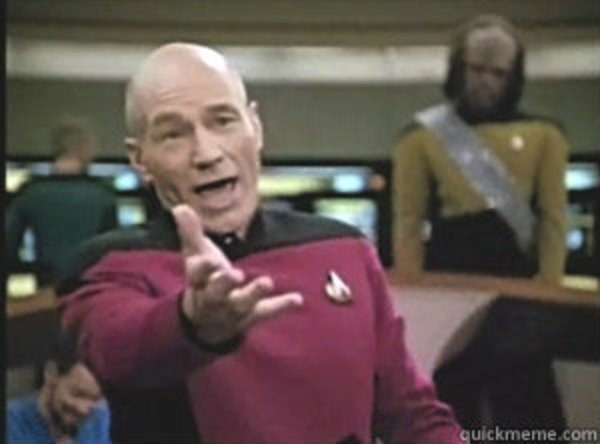

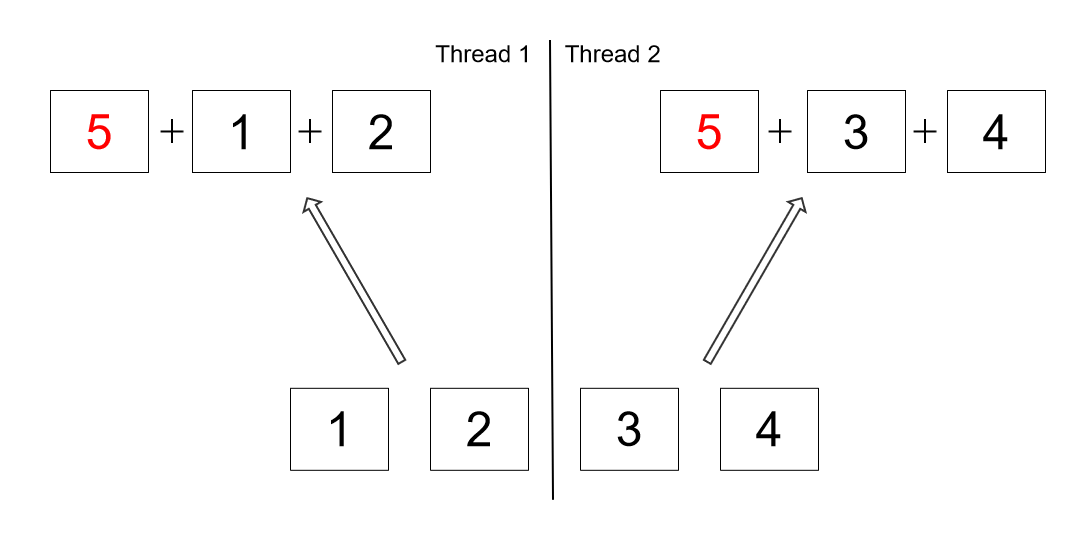

**Wniosek:** trzeba uważać co zrównoleglamy i w jakich sytuacjach używamy `parallel()`.

Uwaga: podobnie jak w przypadku metod na `ConcurrentHashMap`, metoda `parallel` tworzy strumień korzystający z CommonPool, co może mieć negatywne konsekwencje, jeśli jakiś wątek w tej puli będzie przetwarzał się bardzo długo. https://www.baeldung.com/java-8-parallel-streams-custom-threadpool

# Współbieżność w JavaFX

* `Platform.runLater(Runnable r)`
* `javafx.concurrent.Task`
* `javafx.concurrent.Service`

# runLater

In [ ]:
public class MyApplication extends Application {

  @Override
  public void start(Stage primaryStage) {
    ProgressBar progressBar = new ProgressBar(0);

    VBox vBox = new VBox(progressBar);
    Scene scene = new Scene(vBox, 960, 600);
    primaryStage.setScene(scene);
    primaryStage.show();

    Thread taskThread = new Thread(new Runnable() {
      @Override
      public void run() {
        double progress = 0;
        for(int i=0; i<10; i++){
          try {
            Thread.sleep(1000);
          } catch (InterruptedException e) {
            e.printStackTrace();
          }

          progress += 0.1;
          final double reportedProgress = progress;

          Platform.runLater(new Runnable() {              // <-----
            @Override
            public void run() {
              progressBar.setProgress(reportedProgress);
            }
          });
        }
      }
    });

    taskThread.start();
  }
}
// źródło: http://tutorials.jenkov.com/javafx/concurrency.html

# Task

In [ ]:
// źródło: https://docs.oracle.com/javafx/2/threads/jfxpub-threads.htm

import javafx.concurrent.Task;

Task task = new Task<Void>() {
    @Override public Void call() {
        static final int max = 1000000;
        for (int i=1; i<=max; i++) {
            if (isCancelled()) {
               break;
            }
            updateProgress(i, max);
        }
        return null;
    }
};
ProgressBar bar = new ProgressBar();
bar.progressProperty().bind(task.progressProperty());
new Thread(task).start();

# Service

In [ ]:
// źródło: https://docs.oracle.com/javafx/2/threads/jfxpub-threads.htm

public class FirstLineServiceApp extends Application {

    @Override
    public void start(Stage stage) throws Exception {
        FirstLineService service = new FirstLineService();
        service.setUrl("http://google.com");
        service.setOnSucceeded(new EventHandler<WorkerStateEvent>() {
            @Override
            public void handle(WorkerStateEvent t) {
                System.out.println("done:" + t.getSource().getValue());
            }
        });
        service.start();
    }

    public static void main(String[] args) {
        launch();
    }
}

In [ ]:
class FirstLineService extends Service<String> {
    private StringProperty url = new SimpleStringProperty();

    public final void setUrl(String value) {
        url.set(value);
    }

    public final String getUrl() {
        return url.get();
    }

    public final StringProperty urlProperty() {
       return url;
    }

    @Override
    protected Task<String> createTask() {
        final String _url = getUrl();
        return new Task<String>() {
            protected String call() 
                throws IOException, MalformedURLException {
                    String result = null;
                    BufferedReader input = null;
                    try {
                        URL currentUrl = new URL(_url);
                        input = new BufferedReader(new InputStreamReader(currentUrl.openStream()));
                        result = input.readLine();
                    } finally {
                        if (input != null) {
                            input.close();
                        }
                    }
                    return result;
            }
        };
    }
}

![Pytania? ](img/question.jpg)